# Lecture 9 Ensemble Methods

In [1]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## 1. Ensemble Methods

We will work on four topics under ensemble methods: (1) voting classifier, (2) bagging, (3) random forest, and (4) AdaBoost. To show the value of ensemble methods, we use with a classification problem that is NOT linear separable. In below, we first generate and split the data.

### 1.0 Data Prep

Using syntax: sklearn.datasets.make_moons(), we can generate a dataset where points form up two moon shapes. This is often used to show how our classifier works for non-linear separable cases.

In [2]:
# Data Generation
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# make_moons will generate two moon-shaped datasets

In [3]:
# Data Splittion
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

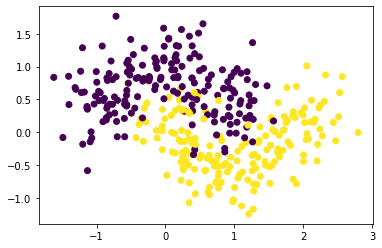

In [4]:
# Visualize our data
plt.scatter(X_train[:,0], X_train[:, 1], c=y_train)

### 1.1 Voting Classifier


Voting classifier will take the result of multiple classification models to make the final prediction (based on majority vote). Therefore, we need to specify a couple of classification models first. Note that in practice, this process is more natural. Suppose we try different models and are debating on which one to choose. Voting classifier is saying that, we can combine the result instead of choosing only one of them.

The process is realized through syntax: 
**<center>sklearn.ensemble.VotingClassifier</center>**
- estimators: the models to use. You need to define a list to store all the models. Each element of a list should include two elements: ('MODEL_NAME', model). The 'MODEL_NAME' is a string.
- voting: the voting method. If "hard", then vote based on predicted label. If "soft", then vote based on predicted probability (i.e., mean of P(y=1)). Default is "hard".

Similar to other models, use .fit() to train the model, use .predict() for prediction, use .score() for accuracy.


**Practice:**

Suppose we want to combine the result of three classifiers: (1) Logistic Regression, (2) SVM, and (3) Naive Bayes. 
- What is the model performance of my voting classifier? 
- What is the model performance of each classifier by itself?

In [5]:
# S1: Define Functions/Estimators

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(kernel = 'rbf', random_state=42) 
nbg_clf = GaussianNB()

In [6]:
# S2: Apply Voting Classifier

from sklearn.ensemble import VotingClassifier
# define voting classifier
voting_clf = VotingClassifier(
    estimators = [  ('Logistic', log_clf)  , ('Kernel_SVM', svm_clf) , ('Gaussian_NB', nbg_clf )],
    voting = 'hard')

# train the model
voting_clf.fit(X_train, y_train)
# Performance Measure
print("Test score for voting classifier is:", voting_clf.score(X_test, y_test))

Test score for voting classifier is: 0.864


#### Extension: Using Loop for Automation
To compare the accuracy, we can run each model manually and print the test score. However, we can also use a loop to automate this process. 

In [7]:
for clf in (log_clf, nbg_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    print('The Performance of Model:', clf.__class__.__name__, "is:", clf.score(X_test, y_test))
    
# The trick is to find model name automatically. This is realized using: 
## clf.__class__.__name__
## Intuitively, it means: 
## for the current clf, find its model (__class__), then get its model name (__name__)

## Object Oriented Programming - Class

The Performance of Model: LogisticRegression is: 0.864
The Performance of Model: GaussianNB is: 0.856
The Performance of Model: SVC is: 0.896
The Performance of Model: VotingClassifier is: 0.864


### 1.2 Bagging Ensemble

Bagging will apply **one same** model on multiple **different resampled** training sets. Suppose each time, we use $B$ records to train our model, and we want to train our model $K$ times. This case, we will have $K$ different prediction results, and we would like to combine these results for our final prediction. 


Based on the above-shown process, we need to specify: (1) the model to use, (2) how many records to take each time (i.e., $B$), and (3) how many times to train our model (i.e., $K$). In Python, it can be realized using syntax:

**<center>sklearn.ensemble.BaggingClassifier()</center>**
We need to specify: 
- estimator, the model to use (e.g., logistic regression, knn, decision tree, svm, etc.) This should be specified in the first element.
- n_estimators, the number of times to run the model, i.e., $K$.
- max_samples, the number of records to use to train the model, i.e., $B$.
- bootstrap, whether sample with/without replacement. Default: True.
- random_state, for replication (resampling procedure)

**Note:**
Bagging goes well with models with a worse scalability. For example, SVM is often used together with bagging. In this case, SVM should be trained on smaller (bootstrapped) samples.

**Practice:**
Suppose we want to train decision tree with default setting on multiple samples, then combine the results. Specifically, we want to train the model 200 times (i.e., N=200), each time with a bootstrapped sample size of 100 (i.e., B=100).

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

bag_clf = BaggingClassifier(dt, max_samples = 100, n_estimators = 200, bootstrap = True,
                            random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.score(X_test, y_test)

0.904

**Practice:**
Now train the naive decision tree classifier. What is the accuracy for test set?

In [13]:
# Practice for you: naive DT: depth = 1, how about bagging it?
dt_naive = DecisionTreeClassifier(max_depth = 1, random_state=42)
dt_naive.fit(X_train, y_train)
print("Accuracy for a naive DT is:", dt_naive.score(X_test, y_test))

bagnaive_clf = BaggingClassifier(dt_naive, max_samples = 100, n_estimators = 200, bootstrap = True,
                            random_state=42)
bagnaive_clf.fit(X_train, y_train)
print("Bagging the naive trees, we have accuracy:", bagnaive_clf.score(X_test, y_test))

# Bagging does not guarantee performance improvement

Accuracy for a naive DT is: 0.824
Bagging the naive trees, we have accuracy: 0.808


### 1.3 Random Forest

Random Forest can be realized using: 
**<center>sklearn.ensemble.RandomForestClassifier</center>**

Recall that Random Forest is an implementation of ensemble learning (bagging) on decision tree models. Thus, most (if not all) the parameters in bagging and decision tree are applicable. Below, we emphasize a couple of parameters:

- n_estimators: number of trees in the forest/number of times to run decision tree
- max_samples: number of records to sample for each tree
- max_features: number of features to choose (the $m$ in the lecture note)
- bootstrap: True when sample with replacement

Notably, all the pre-pruning hyperparameters in DT are also valid in Random Forest. Similar to DT, Random Forest can provide **.feature_importances_**. In this case, the numbers would be the mean of impurity improvement across different leaners.

**Practice**
Train a Random Forest Classifier with 200 trees, each using a bootstrapped sample with 100 instances. Let random state be 42. What is the model's performance?

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200, max_samples = 100, random_state = 42) # features as default
# estimator dropped, estimator will be tree
rf.fit(X_train, y_train)
rf.score(X_test, y_test), rf.feature_importances_

(0.92, array([0.43339532, 0.56660468]))

### 1.4 AdaBoost

AdaBoost focuses on one classifier as well. The key difference between AdaBoost and Bagging is that, it applies different weights to samples, and combine results using a weighted method.

The method is realized using syntax: 
**<center>sklearn.ensemble.AdaBoostClassifier</center>**
- The first element should be the model we use.
- n_estimators: number of times to run the model
- learning_rate: the importance of each classifier. default is 1.
- random_state

**Practice**
Suppose we apply Adaboost to naive DT classifier with depth = 1. Let learning rate be 0.5, random state be 42. What is the performance if we train 200 naive learners?


In [19]:
from sklearn.ensemble import AdaBoostClassifier

# Define base model
dt1 = DecisionTreeClassifier(max_depth = 1, random_state = 42)
# AdaBoost
adaboost = AdaBoostClassifier(dt1, n_estimators = 200, learning_rate = 0.5, random_state = 42)
adaboost.fit(X_train, y_train)
# Performance
adaboost.score(X_test, y_test) # with boosting, each learner's performance can be slightly below 0.5

0.896